# Кривые обмена AMM: Uniswap (x·y=k) и HFMM (Curve CryptoInvariant)
Визуализация теоретических кривых для двух пулов при одинаковых резервах. HFMM использует модифицированный численный решатель (бинпоиск).

In [ ]:
import sys
from pathlib import Path
import os
import importlib.util
import matplotlib.pyplot as plt
import seaborn as sns

cwd = Path(os.getcwd()).resolve()
repo_root = cwd
for parent in [cwd] + list(cwd.parents):
    if (parent / "AgentBasedModel").exists():
        repo_root = parent
        break
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

pools_path = repo_root / "AgentBasedModel" / "utils" / "pools.py"
spec = importlib.util.spec_from_file_location("pools_local", pools_path)
pools_local = importlib.util.module_from_spec(spec)
spec.loader.exec_module(pools_local)
ConstantProductPool = pools_local.ConstantProductPool
HFPool = pools_local.HFPool
repo_root

PosixPath('/Users/mihailledenev/PycharmProjects/AI_360_project')

## Параметры пулов
Базовые резервы одинаковые. HFMM использует A и γ из кода (по умолчанию 100 и 1e-3).

In [ ]:
x0, y0 = 100.0, 100.0
A = 100.0
gamma = 1e-3

cp = ConstantProductPool(x0, y0)
hf = HFPool(x0, y0, A=A, gamma=gamma)
cp.curve_points(5), hf.curve_points(5)

(([40.0, 80.0, 120.0, 160.0, 200.0],
  [250.0, 125.0, 83.33333333333333, 62.5, 50.0]),
 ([40.0, 80.0, 120.0, 160.0, 200.0],
  [237.00212345966787,
   122.85989703452265,
   82.05935030911931,
   60.41357758964641,
   47.781579480451526]))

## Кривые x→y
Строим зависимости y(x) по теории (без комиссий).

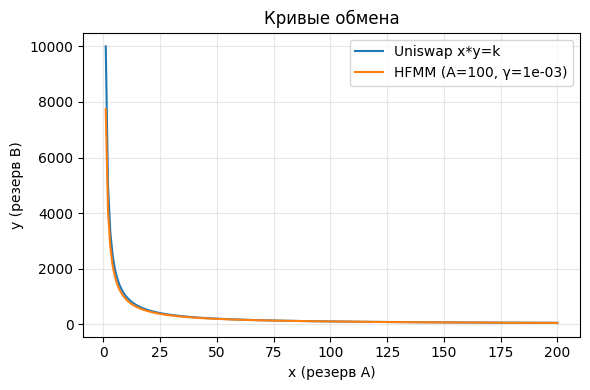

In [11]:
xs_cp, ys_cp = cp.curve_points(n=200)
xs_hf, ys_hf = hf.curve_points(n=200)

plt.figure(figsize=(6, 4))
plt.plot(xs_cp, ys_cp, label="Uniswap x*y=k")
plt.plot(xs_hf, ys_hf, label="HFMM (A=%.0f, γ=%.0e)" % (A, gamma))
plt.xlabel("x (резерв A)")
plt.ylabel("y (резерв B)")
plt.title("Кривые обмена")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Маргинальная цена и slippage
Приращение dx=1: считаем котировку (dy/dx) и проскальзывание относительно спотовой цены.

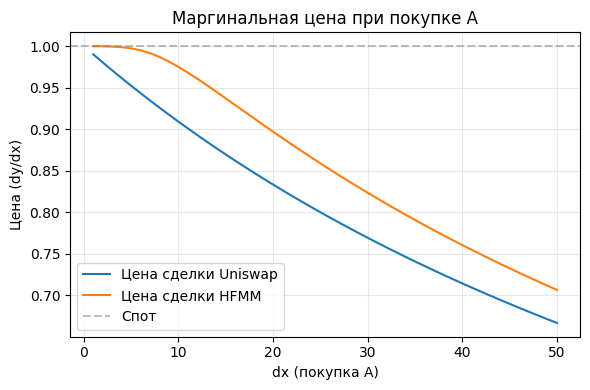

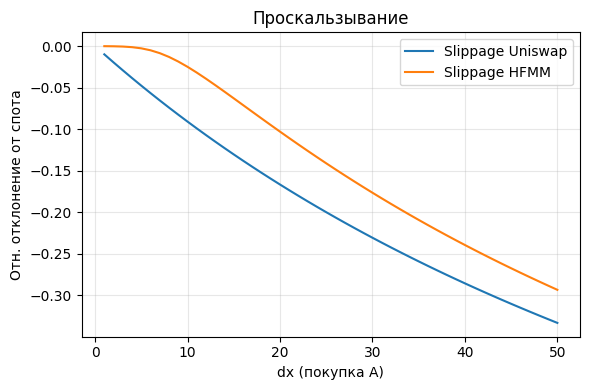

In [ ]:
def slippage_curve(pool, max_dx=50, step=1.0):
    prices = []
    slips = []
    dxs = []
    base_price = pool.spot_price()
    for mult in range(1, int(max_dx/step)+1):
        dx = mult*step
        price = pool.quote_out(dx)/dx if dx>0 else float('nan')
        prices.append(price)
        dxs.append(dx)
        slips.append((price/base_price - 1) if base_price>0 else float('nan'))
    return dxs, prices, slips

dxs_cp, prices_cp, slips_cp = slippage_curve(ConstantProductPool(x0,y0), max_dx=50, step=1)
dxs_hf, prices_hf, slips_hf = slippage_curve(HFPool(x0,y0,A=A,gamma=gamma), max_dx=50, step=1)

plt.figure(figsize=(6,4))
plt.plot(dxs_cp, prices_cp, label="Цена сделки Uniswap")
plt.plot(dxs_hf, prices_hf, label="Цена сделки HFMM")
plt.axhline(ConstantProductPool(x0,y0).spot_price(), color='gray', ls='--', alpha=0.5, label='Спот')
plt.xlabel("dx (покупка A)")
plt.ylabel("Цена (dy/dx)")
plt.title("Маргинальная цена при покупке A")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(dxs_cp, slips_cp, label="Slippage Uniswap")
plt.plot(dxs_hf, slips_hf, label="Slippage HFMM")
plt.xlabel("dx (покупка A)")
plt.ylabel("Отн. отклонение от спота")
plt.title("Проскальзывание")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

При покупке A (dx>0) запас A в пуле растёт, цена сделки падает относительно спота — кривые идут вниз, что нормально для x*y=k.
HFMM (оранжевая) лежит выше синей: при тех же dx маржинальная цена выше, т.е. проскальзывание (отн. отклонение от спота) менее отрицательное. Это отражает более концентрированную ликвидность вокруг паритета в HFMM.
Спот (серый) постоянен: мы сравниваем маргинальные цены при заборе ликвидности. Падение ниже спота — ожидаемое поведение.